FreeGS for fixed boundaries
=======================

A Grad-Shafranov solver, written in python. It can be used to perform simple fixed boundary calculations in rectangular domains.

 - Available on [github](https://github.com/bendudson/freegs.git)
 - Manual on [Readthedocs](http://freegs.readthedocs.io/en/latest/)

Install FreeGS from [PyPI](https://pypi.org/project/FreeGS/) by running in a terminal:
```bash
$ pip install --user freegs
```
(Here using version 0.1.6)

Solves

$$
\Delta^* \psi\left(R,Z\right) = -\mu_0RJ_\phi\left(R,Z\right)
$$

where the toroidal current density is 

$$
J_\phi = R\frac{dp\left(\psi\right)}{d\psi} + \frac{1}{\mu_0 R}f\left(\psi\right)\frac{d f\left(\psi\right)}{d\psi}
$$

In [ ]:
# Plasma equilibrium (Grad-Shafranov) solver
import freegs

# Boundary conditions
import freegs.boundary as boundary

Plasma profiles
----------------------

Specify the profiles $p\left(\psi\right)$ and $f\left(\psi\right)$ which determine the plasma current:

$$
J_\phi = R\frac{dp\left(\psi\right)}{d\psi} + \frac{1}{\mu_0 R}f\left(\psi\right)\frac{d f\left(\psi\right)}{d\psi}
$$

YoungMu Jeon [arXiv:1503.03135](https://arxiv.org/abs/1503.03135)

$$
J_\phi = \lambda \left(\beta_0 \frac{R}{R_0} + \left(1-\beta_0\right)\frac{R_0}{R}\right) \tilde{j}
$$

where $\tilde{j}$ is a shape function which depends on the normalised flux $0 \le \psi_n \le 1$ inside the plasma:

$$
\psi_n = \frac{\psi - \psi_{axis}}{\psi_{boundary} - \psi_{axis}}
$$

The shape function $\tilde{j}$ is chosen to be 

$$
\tilde{j} = \left(1 - \psi_n^{\alpha_m}\right)^{\alpha_n}
$$

where $\alpha_m$ and $\alpha_n$ are constants.

The values $\beta_0$ and $L$ are set using two constraints:
 
 * Maximum plasma pressure, and plasma current: [ConstrainPaxisIp](https://github.com/bendudson/freegs/blob/master/freegs/jtor.py#L276)
 * Poloidal beta, and plasma current: [ContrainBetapIp](https://github.com/bendudson/freegs/blob/master/freegs/jtor.py#L125)

In [2]:
profiles = freegs.jtor.ConstrainPaxisIp(1e3, # Plasma pressure on axis [Pascals]
                                        1e5, # Plasma current [Amps]
                                        1.0) # fvac = R*Bt

Specify computational domain
-------------------------------------------

A rectangular grid in R-Z (cylindrical coordinates). 

Number of points in x (R) and y (Z) is ($2^k + 1$) for some integer $k$. This is so that the [Romberg](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.romb.html) integration method can be used. It also enables [multigrid methods](https://github.com/bendudson/freegs/blob/master/freegs/multigrid.py#L110) to be used to solve large grids efficiently.

The boundary is set to `fixedBoundary` so $\psi=0$ on the boundary cells.

In [3]:
eq = freegs.Equilibrium(Rmin=0.1, Rmax=2.0,
                        Zmin=-1.0, Zmax=1.0,
                        nx=65, ny=65,
                        boundary=boundary.fixedBoundary)

Nonlinear solve
----------------------

The equilibrium `eq` starts with an initial guess for $\psi$. 

Next we use the Picard method in [freegs.solve](https://github.com/bendudson/freegs/blob/master/freegs/picard.py#L24)

In each iteration we:

1. Calculate the toroidal current [in eq.solve](https://github.com/bendudson/freegs/blob/master/freegs/equilibrium.py#L342) using $\psi^n$ as input to the `ConstrainPaxisIp` object [here](https://github.com/bendudson/freegs/blob/master/freegs/jtor.py#L308)
2. Set boundary conditions [in eq.solve](https://github.com/bendudson/freegs/blob/master/freegs/equilibrium.py#L347) by calling the [fixedBoundary function](https://github.com/bendudson/freegs/blob/master/freegs/boundary.py#L28)
3. Solve the elliptic operator to get $\psi$ [in eq.solve](https://github.com/bendudson/freegs/blob/master/freegs/equilibrium.py#L295) to get $\psi^{n+1}$
4. Check if $\left|\psi^{n+1} - \psi^n\right| < \epsilon$ [in freegs.solve](https://github.com/bendudson/freegs/blob/master/freegs/picard.py#L90)
5. (optional) Blend previous and current $\psi$ [in freegs.solve](https://github.com/bendudson/freegs/blob/master/freegs/picard.py#L104)

In [4]:
# Nonlinear solver for Grad-Shafranov equation
freegs.solve(eq,           # The equilibrium to adjust
             profiles)     # The toroidal current profile function

Constraints: L = 9.469954e+04, Beta0 = 3.167914e-02
Maximum change in psi: 9.850584e-01. Relative: 6.454111e+01
Constraints: L = 9.961625e+04, Beta0 = 1.973174e+00
Maximum change in psi: 1.438935e-02. Relative: 5.229873e-01
Constraints: L = 1.387389e+05, Beta0 = 7.859101e-01
Maximum change in psi: 1.828429e-03. Relative: 6.620406e-02
Constraints: L = 1.469346e+05, Beta0 = 7.389548e-01
Maximum change in psi: 1.096856e-03. Relative: 3.898391e-02
Constraints: L = 1.536034e+05, Beta0 = 6.938177e-01
Maximum change in psi: 5.070937e-04. Relative: 1.787156e-02
Constraints: L = 1.568297e+05, Beta0 = 6.739862e-01
Maximum change in psi: 2.317018e-04. Relative: 8.134769e-03
Constraints: L = 1.582921e+05, Beta0 = 6.653924e-01
Maximum change in psi: 1.058565e-04. Relative: 3.710294e-03
Constraints: L = 1.590074e+05, Beta0 = 6.612945e-01
Maximum change in psi: 4.742136e-05. Relative: 1.660914e-03
Constraints: L = 1.593254e+05, Beta0 = 6.594919e-01
Maximum change in psi: 2.123570e-05. Relative: 7.435

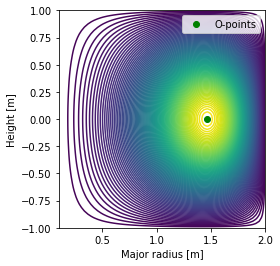

In [5]:
# Plot equilibrium
%matplotlib inline
from freegs.plotting import plotEquilibrium

plotEquilibrium(eq)

Diagnostics
-----------------
Some properties of the plasma can be calculated. See the [diagnostics page in the manual](https://freegs.readthedocs.io/en/latest/diagnostics.html).

In [6]:
eq.plasmaCurrent()  # Plasma current in Amps

100000.00000000001

In [7]:
eq.poloidalBeta()  # Poloidal beta

0.7220029298396231